In [19]:
import pandas as pd
from sklearn import preprocessing
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x=pd.read_csv("./BIKED_processed.csv", index_col=0)

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns,index=x.index.values).astype('float32')

In [21]:
images=[]
for i in x.index.values:
    try:
        filePath="./Test Resized/(" + str(i) + ").png"
        image=np.asarray(Image.open(filePath).convert('L'))
        images.append(image/255)
    except:
        pass
images=np.stack(images, axis=0)
np.save("test_images.npy", images)

In [5]:
with open("images.npy", 'rb') as f:
    images = np.load(f)

In [6]:
param_train, param_val, image_train, image_val = train_test_split(x_scaled, images, test_size=0.2, random_state=42)
image_train=tf.cast(tf.expand_dims(image_train, -1), tf.float32)
image_val=tf.cast(tf.expand_dims(image_val, -1), tf.float32)


In [7]:
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [8]:
def create_renderer(dim_x, dim_y):
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(dim_x)))

    model.add(tf.keras.layers.Dense(30*65, name="layer1"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.1)) 
    model.add(tf.keras.layers.Reshape(target_shape=(30, 65, 1)))

    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))
    model.summary()
    return model
#     def build_vae_keras_model(self):
#         x_input = keras.Input(shape=self.dim_x)
#         network = self.ConvTransposeNetwork()
#         encoder.summary()
#         output = network(x_input)

#             # compile VAE model
#         model = keras.Model(inputs=x_input, outputs=output)

In [9]:
dim_x=len(param_train.columns)
dim_y=np.shape(image_train[1])
renderer=create_renderer(dim_x, dim_y)
renderer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=custom_sigmoid_cross_entropy_loss_with_logits)
# tf.nn.sigmoid_cross_entropy_with_logits

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1950)              4683900   
_________________________________________________________________
batch_normalization (BatchNo (None, 1950)              7800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1950)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1950)              0         
_________________________________________________________________
reshape (Reshape)            (None, 30, 65, 1)         0         
_________________________________________________________________
d1 (Conv2DTranspose)         (None, 60, 130, 128)      1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 130, 128)      5

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = renderer.fit(x=param_train, y=image_train, epochs=1000, batch_size=100, validation_data=(param_val, image_val), callbacks=[callback])

Epoch 1/1000
37/37 [==============================] - 10s 142ms/step - loss: 17486.9121 - val_loss: 20833.3613
Epoch 2/1000
37/37 [==============================] - 5s 133ms/step - loss: 14573.7842 - val_loss: 19221.1230
Epoch 3/1000
37/37 [==============================] - 5s 133ms/step - loss: 13825.9561 - val_loss: 17549.3242
Epoch 4/1000
37/37 [==============================] - 5s 134ms/step - loss: 13239.0566 - val_loss: 16315.1836
Epoch 5/1000
37/37 [==============================] - 5s 134ms/step - loss: 12523.0479 - val_loss: 15377.6602
Epoch 6/1000
37/37 [==============================] - 5s 135ms/step - loss: 11919.8018 - val_loss: 14608.5732
Epoch 7/1000
37/37 [==============================] - 5s 134ms/step - loss: 11489.8965 - val_loss: 14038.6309
Epoch 8/1000
37/37 [==============================] - 5s 146ms/step - loss: 11200.5146 - val_loss: 13532.6729
Epoch 9/1000
37/37 [==============================] - 5s 140ms/step - loss: 10952.1104 - val_loss: 13102.9922
Epoch 10/

In [11]:
def plotcomparison(preds, actual, indices):
    fig = plt.figure(figsize=(25, 15))
    for i in range(16):
        if i%2==1:
            idx=indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(preds[i//2,:,:,:], cmap="gray")
            plt.title("Model " + str(idx), fontsize=20)
            plt.axis('off')
        else:
            idx=indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(actual[i//2,:,:,:], cmap="gray")
            plt.title("Model " + str(idx), fontsize=20)
            plt.axis('off')

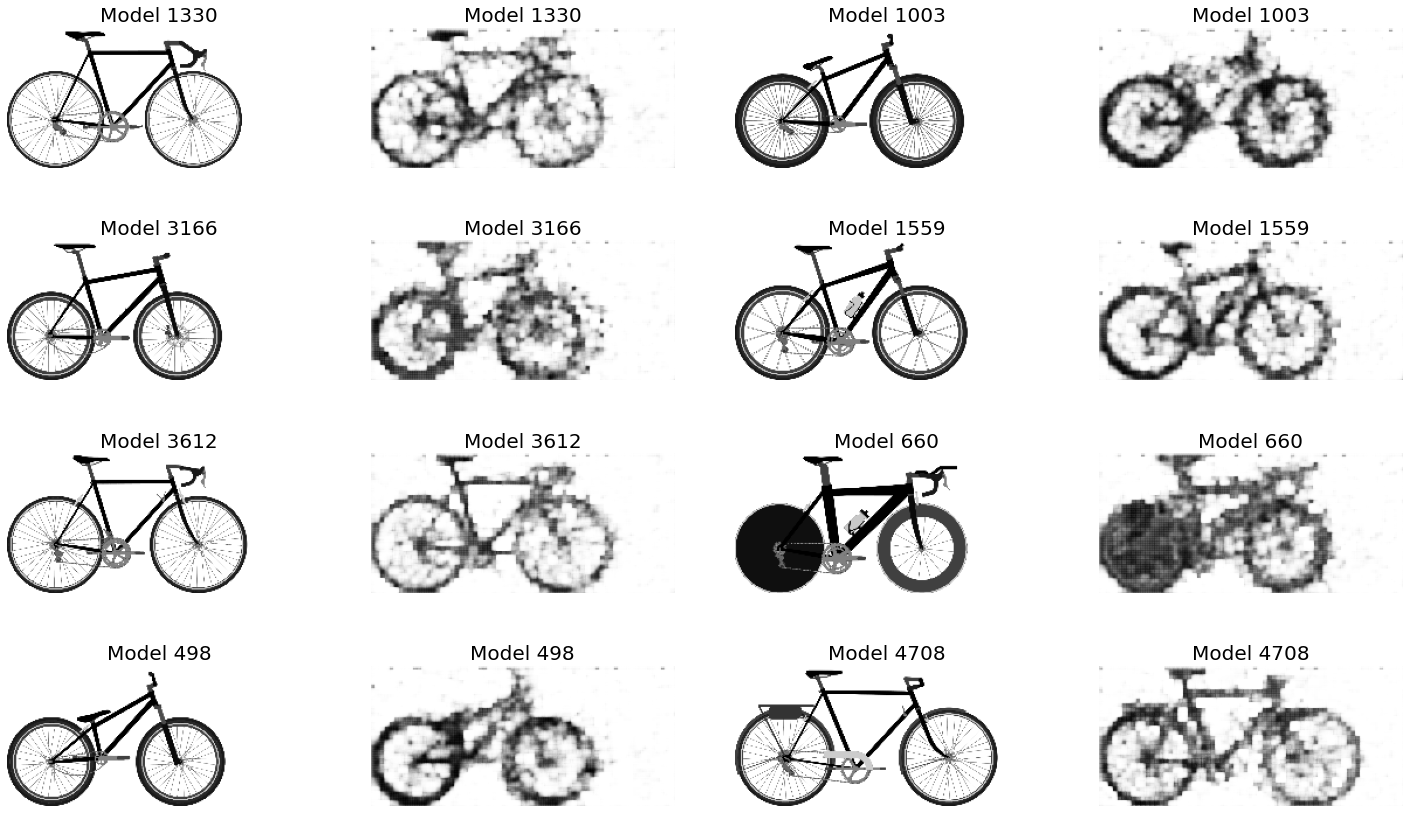

In [12]:
#Why do we need sigmoid here? 
#Tensorflow's sigmoid cross entropy loss calculates the cross entropy of the sigmoid of the output vs the targets
#Therefore, we need to take the sigmoid of the NN's output to get our image
preds=tf.sigmoid(renderer.predict(param_train[:8]))
plotcomparison(preds, image_train[:8], param_train.index[:8])

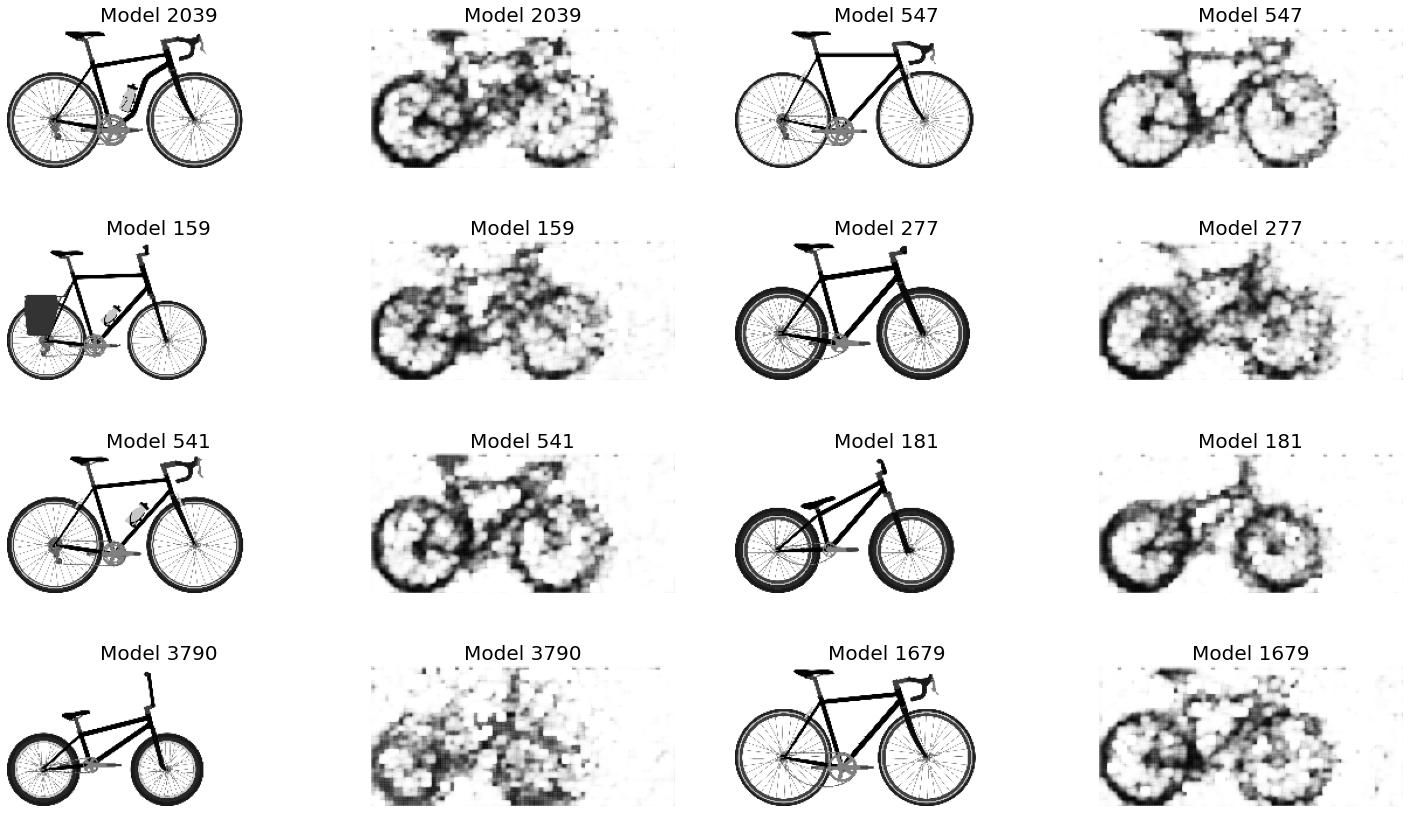

In [13]:
preds=tf.sigmoid(renderer.predict(param_val[:8]))
plotcomparison(preds, image_val, param_val.index[:8])

In [17]:
score=0
preds=tf.sigmoid(renderer.predict(param_val))
for i in range(len(param_val.index)):
    score+=tf.image.ssim(image_val[i], preds[i], 1, filter_size=11)
score=score/len(param_val.index)
print(score)

tf.Tensor(0.42220536, shape=(), dtype=float32)
